# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


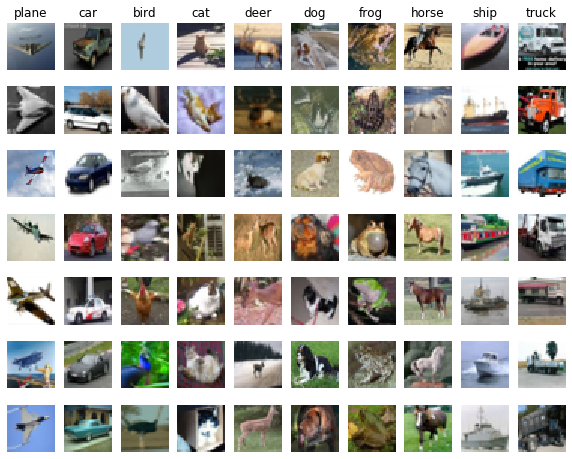

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


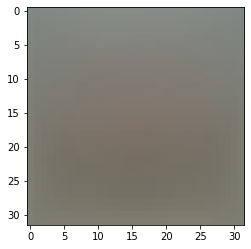

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [8]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.490889


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [9]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -2.266062 analytic: -2.266062, relative error: 5.192027e-11
numerical: 26.988108 analytic: 26.988108, relative error: 7.767811e-12
numerical: 0.209707 analytic: 0.209707, relative error: 1.125838e-09
numerical: 5.411034 analytic: 5.411034, relative error: 4.001727e-11
numerical: 36.460096 analytic: 36.460096, relative error: 4.071871e-12
numerical: -14.335365 analytic: -14.335365, relative error: 5.186743e-12
numerical: -14.244346 analytic: -14.244346, relative error: 1.936243e-11
numerical: 7.161221 analytic: 7.161221, relative error: 3.416238e-11
numerical: -2.521394 analytic: -2.521394, relative error: 5.774125e-11
numerical: -9.642677 analytic: -9.642677, relative error: 4.996431e-11
numerical: 7.946714 analytic: 7.946714, relative error: 8.088616e-12
numerical: 21.257877 analytic: 21.257877, relative error: 1.990036e-11
numerical: -9.595837 analytic: -9.595837, relative error: 4.080942e-11
numerical: -44.597154 analytic: -44.597154, relative error: 3.522111e-12
numerica

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  


In [10]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.490889e+00 computed in 0.095815s
Vectorized loss: 9.490889e+00 computed in 0.005121s
difference: 0.000000


In [11]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.096467s
Vectorized loss and gradient: computed in 0.003464s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [12]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 793.499063
iteration 100 / 1500: loss 290.878631
iteration 200 / 1500: loss 109.025656
iteration 300 / 1500: loss 43.034922
iteration 400 / 1500: loss 19.207057
iteration 500 / 1500: loss 10.186299
iteration 600 / 1500: loss 7.861412
iteration 700 / 1500: loss 6.221406
iteration 800 / 1500: loss 5.154690
iteration 900 / 1500: loss 5.247553
iteration 1000 / 1500: loss 4.588891
iteration 1100 / 1500: loss 6.002320
iteration 1200 / 1500: loss 5.021101
iteration 1300 / 1500: loss 5.267557
iteration 1400 / 1500: loss 5.246771
That took 5.679331s


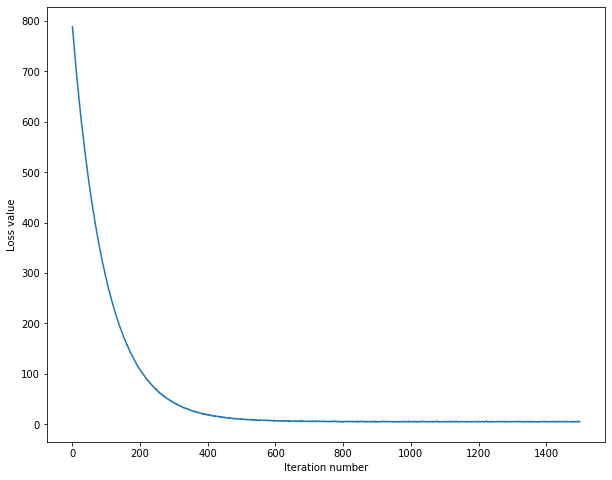

In [28]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [32]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.366857
validation accuracy: 0.381000


In [47]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

#Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

RANGE = 10
range_lr = np.linspace(learning_rates[0], learning_rates[-1], RANGE)
range_rs = np.linspace(regularization_strengths[0], regularization_strengths[-1], RANGE)
hp_comb = [(lr, rs) for lr in range_lr for rs in range_rs]

for lr, rs in hp_comb:
    model = LinearSVM()
    
    model.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=1500, verbose=True)
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    train_acc = np.mean(y_train == y_train_pred)
    val_acc = np.mean(y_val == y_val_pred)
    
    results[(lr, rs)] = (train_acc, val_acc)
    if val_acc > best_val:
        best_val = val_acc
        best_svm = model
    
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 790.918981
iteration 100 / 1500: loss 287.839831
iteration 200 / 1500: loss 108.511304
iteration 300 / 1500: loss 42.534561
iteration 400 / 1500: loss 18.638698
iteration 500 / 1500: loss 9.912406
iteration 600 / 1500: loss 7.241007
iteration 700 / 1500: loss 5.952837
iteration 800 / 1500: loss 5.601510
iteration 900 / 1500: loss 5.460875
iteration 1000 / 1500: loss 5.382678
iteration 1100 / 1500: loss 5.370614
iteration 1200 / 1500: loss 5.201844
iteration 1300 / 1500: loss 5.190268
iteration 1400 / 1500: loss 5.249115
iteration 0 / 1500: loss 872.548968
iteration 100 / 1500: loss 285.746506
iteration 200 / 1500: loss 96.363843
iteration 300 / 1500: loss 34.636440
iteration 400 / 1500: loss 15.166628
iteration 500 / 1500: loss 8.034030
iteration 600 / 1500: loss 6.006156
iteration 700 / 1500: loss 6.089001
iteration 800 / 1500: loss 5.638835
iteration 900 / 1500: loss 5.400200
iteration 1000 / 1500: loss 4.920726
iteration 1100 / 1500: loss 5.735233
iteration 

iteration 1400 / 1500: loss 22.983166
iteration 0 / 1500: loss 1218.936519
iteration 100 / 1500: loss 34.995794
iteration 200 / 1500: loss 35.679655
iteration 300 / 1500: loss 26.173844
iteration 400 / 1500: loss 22.590344
iteration 500 / 1500: loss 30.311024
iteration 600 / 1500: loss 33.730353
iteration 700 / 1500: loss 38.746514
iteration 800 / 1500: loss 31.912039
iteration 900 / 1500: loss 42.715040
iteration 1000 / 1500: loss 31.880030
iteration 1100 / 1500: loss 33.094568
iteration 1200 / 1500: loss 27.170611
iteration 1300 / 1500: loss 32.641156
iteration 1400 / 1500: loss 24.004378
iteration 0 / 1500: loss 1296.055560
iteration 100 / 1500: loss 40.076246
iteration 200 / 1500: loss 27.006800
iteration 300 / 1500: loss 45.459220
iteration 400 / 1500: loss 23.625391
iteration 500 / 1500: loss 35.774378
iteration 600 / 1500: loss 35.930729
iteration 700 / 1500: loss 29.588115
iteration 800 / 1500: loss 37.899572
iteration 900 / 1500: loss 34.185007
iteration 1000 / 1500: loss 31.2

iteration 800 / 1500: loss 170.053841
iteration 900 / 1500: loss 146.117561
iteration 1000 / 1500: loss 220.324867
iteration 1100 / 1500: loss 167.920669
iteration 1200 / 1500: loss 199.414237
iteration 1300 / 1500: loss 202.839356
iteration 1400 / 1500: loss 197.290163
iteration 0 / 1500: loss 793.854044
iteration 100 / 1500: loss 120.648035
iteration 200 / 1500: loss 130.199540
iteration 300 / 1500: loss 139.507667
iteration 400 / 1500: loss 162.174255
iteration 500 / 1500: loss 198.276496
iteration 600 / 1500: loss 179.659898
iteration 700 / 1500: loss 163.602682
iteration 800 / 1500: loss 135.891594
iteration 900 / 1500: loss 124.623661
iteration 1000 / 1500: loss 107.239226
iteration 1100 / 1500: loss 167.322668
iteration 1200 / 1500: loss 153.650577
iteration 1300 / 1500: loss 165.411219
iteration 1400 / 1500: loss 166.429202
iteration 0 / 1500: loss 879.559359
iteration 100 / 1500: loss 242.475205
iteration 200 / 1500: loss 163.001207
iteration 300 / 1500: loss 173.269760
iterat

iteration 1200 / 1500: loss 947.640073
iteration 1300 / 1500: loss 907.185491
iteration 1400 / 1500: loss 826.658259
iteration 0 / 1500: loss 1123.659310
iteration 100 / 1500: loss 1608.785074
iteration 200 / 1500: loss 1380.110526
iteration 300 / 1500: loss 1562.800841
iteration 400 / 1500: loss 1450.821345
iteration 500 / 1500: loss 1509.676068
iteration 600 / 1500: loss 1587.615564
iteration 700 / 1500: loss 1737.627180
iteration 800 / 1500: loss 1180.716619
iteration 900 / 1500: loss 1485.668110
iteration 1000 / 1500: loss 1636.468753
iteration 1100 / 1500: loss 1382.575777
iteration 1200 / 1500: loss 1474.566218
iteration 1300 / 1500: loss 1365.416411
iteration 1400 / 1500: loss 1522.034579
iteration 0 / 1500: loss 1201.617798
iteration 100 / 1500: loss 2836.311244
iteration 200 / 1500: loss 3245.006035
iteration 300 / 1500: loss 2637.136051
iteration 400 / 1500: loss 2836.414625
iteration 500 / 1500: loss 3261.230503
iteration 600 / 1500: loss 2844.933950
iteration 700 / 1500: lo

iteration 0 / 1500: loss 1047.983671
iteration 100 / 1500: loss 11562.448110
iteration 200 / 1500: loss 12401.666766
iteration 300 / 1500: loss 12165.769404
iteration 400 / 1500: loss 11791.986741
iteration 500 / 1500: loss 11345.739585
iteration 600 / 1500: loss 11831.158130
iteration 700 / 1500: loss 10929.822955
iteration 800 / 1500: loss 10777.427427
iteration 900 / 1500: loss 12406.980055
iteration 1000 / 1500: loss 10989.308097
iteration 1100 / 1500: loss 10795.714917
iteration 1200 / 1500: loss 11093.835095
iteration 1300 / 1500: loss 11811.823169
iteration 1400 / 1500: loss 11306.197608
iteration 0 / 1500: loss 1131.945515
iteration 100 / 1500: loss 5997012.364877
iteration 200 / 1500: loss 75248951.745442
iteration 300 / 1500: loss 603816451.893612
iteration 400 / 1500: loss 4227151588.799668
iteration 500 / 1500: loss 28183739028.812744
iteration 600 / 1500: loss 184568496351.361511
iteration 700 / 1500: loss 1200269197461.850586
iteration 800 / 1500: loss 7784166471202.68066

iteration 400 / 1500: loss 38034708883367807777678879989612917182990189239296011193767908273822623871840789452303318398256836708829972874683449167952767023250984086091374990056636048263006547003572224.000000
iteration 500 / 1500: loss 78093554645995427964734257975282245302752694626367941268663243536050777769625450912728372494192789104638605516386730171867282142923948995387186346808842135469219493980181673701792339160451597544611021146508700418048.000000
iteration 600 / 1500: loss 160343103872524501244123227705334173345918476082906660725714749402094650864728174786116992554842375028047390224513079014335494937163776888382593936800245565475253013666578910141011820834050192275928311119538922862260037374389153054852084947735304687709061120.000000
iteration 700 / 1500: loss 329219371253112224641514267552024477882948685339148402895816088980741218601283445307990926704111594400435999687057144689423126855362044632089225004963162661656311861101341943650738049668718654744450505622004317861695406936

/Users/ldreval/Dropbox/Courses/MDLI/assignment1/cs231n/classifiers/linear_svm.py:94: RuntimeWarning: overflow encountered in subtract
  score_label_substract = scores - correct_class_scores + 1                # Shape: [N, C]


iteration 0 / 1500: loss 1550.677992
iteration 100 / 1500: loss 314295422591574515174142056375308649644188640074530816.000000
iteration 200 / 1500: loss 48945070426921810517670142968509905104993518919353054867331827752907789930082880175398707260392105574400.000000
iteration 300 / 1500: loss 7622191565320481266700857024779981553994227577442501358728520641518336606825428750755766206032061302359879418779480691231851495245082964666155629260308480.000000
iteration 400 / 1500: loss 1187000115674295091675723380539054952190116614911262799342976416589736291598323440538797035021594516002860693769305309101165951456062289655639325623694662611319702634578276330109182659953964742408943960064.000000
iteration 500 / 1500: loss 184850939855845561782540158175681501014441293391244791755272960886913642832165381479003494753469930168189225350791406793205702476724083745874578734407994212106192572265940049378069947415018010288081543573961561468061449907298424719512738540228984839340032.000000
iteration 600 / 

iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 1227.804836
iteration 100 / 1500: loss 75789727069948633277888825929695207069057024.000000
iteration 200 / 1500: loss 2765870637281745198703788681605536315741246497250770456919717348266045747048168292352.000000
iteration 300 / 1500: loss 100937695357008929684216723557582563405170490103462443141048776993458052475927259861736099817580664363182156890995954936709120.000000
iteration 400 / 1500: loss 3683620703966604066179258827289457710149709407656931593119305121687831987316643532978151499929336771687538817039595287298368550860283133329314305722340610374742573056.000000
iteration 500 / 1500: loss 134430070378550711181016915282825219112102696867927843543312235644035076337257961438449478272528636007660752160508489396737135288419125624087163438114768797302399603500661746342173613316701693733833738813440.000000
iteration 600 / 1500: loss 4905891587188214457888903731713433741

iteration 600 / 1500: loss 15303566991872951243707026776229050057484962191724536576514514407194110267955871744.000000
iteration 700 / 1500: loss 160588180963548097100268096659550100640753080711473751632227725750398930890293821064415646056448.000000
iteration 800 / 1500: loss 1685134183349309998946526748178678744428684597356143029410601633289897136300197314425429284926117459234127872.000000
iteration 900 / 1500: loss 17682977656599297799376454686649567934744975135891034182187817003602392902947394751601861605308711785419785387378451939328.000000
iteration 1000 / 1500: loss 185556557984185899922532472527594738880645644705419370057103172345818819852221654030652283047017291098487278993722658027138320760307712.000000
iteration 1100 / 1500: loss 1947140175121398928877634856558020551587008185381759789944283718621599628565498574959143963442401338880147862603495685940290971827309105116933521408.000000
iteration 1200 / 1500: loss 2043234096794850164823360809274247625867555544266866421258967274602

iteration 400 / 1500: loss 67539106682985757335253522337405920378988629443813959000684019180705426306174394295603112592827724681990034919578818331188241866054186997025343293973552988156990676232735863756613474676373396841234118420673030285330056266462686644389022734184530681626017220445961857608652053733703680.000000
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf
iteration 700 / 1500: loss inf
iteration 800 / 1500: loss inf
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 1398.484061
iteration 100 / 1500: loss 2265566098160208293716936995117915250340687572858118515442807793900178078823350272.000000
iteration 200 / 1500: loss 3152074562850888852553355957319876662571027653760835791918014361842522416829790322780503452306186011115132199697788229865232697723118700135920870502468822237184.000000
iteration 300 / 1

iteration 300 / 1500: loss 1134008368096503937728824107352343656192362568581623293943950821415319911106806553039966590160953380538632534600192754024224271835086247870595072.000000
iteration 400 / 1500: loss 98840370511039657552377405791329662481482183743327305226008558381563159234855309902532899844826655677568678787783356157582855869126267771464352043069784485136076361100298895259100686420279296.000000
iteration 500 / 1500: loss 8614944225815640992832576884620138457962458210352663885829377784943405354091796418063245826391149105572451206813348264799176846681696978339446254857608928616123425659254097445250297669385378771223729399162913929030447503535192169726869504.000000
iteration 600 / 1500: loss 750880066820720963851694243620132563223691396244842035797005747207448273596576096253581989696736063072513783501158918276216112773914300940786316869090146279478709331930953011162760569167615366092941060840755595345256121314598740247743412670550386349669490097878797299501029593794478080.000000
i

iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 785.290286
iteration 100 / 1500: loss 398849522616364134371056568714519379968.000000
iteration 200 / 1500: loss 65926631734097046400717303194745908252152902526752690867992177315239952384.000000
iteration 300 / 1500: loss 10897144224449249921027369498542251098738899247918516268311140593852954010459953807190955035348893007630827520.000000
iteration 400 / 1500: loss 1801210665932317595780299728442271400898049820972437937317981912047316859069437508909469139232895230941615078387060524616535804715218461551230976.000000
iteration 500 / 1500: loss 29772569732436628730402509679018480485570972416592708814422542507516731600702618237

iteration 200 / 1500: loss 245466703541165290089210898640913670614524679346181855707861076872996118408275252179257936228234844226409097606546417489463206003225557572380444030122460312558941051665239862917807697725496452661645410304.000000
iteration 300 / 1500: loss 3239386024374639697108064460827897166265249778070211718927676421270324415801778526328066447832419426707936727961616465811315102468668702906014148860049502444555271481767913729379436456659138081366804345988936282456291985852439715883818842216267902145251665977216483310754903543175118984750239677786619904.000000
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 1402.634887
iteration 100 / 1500: loss 406410388183

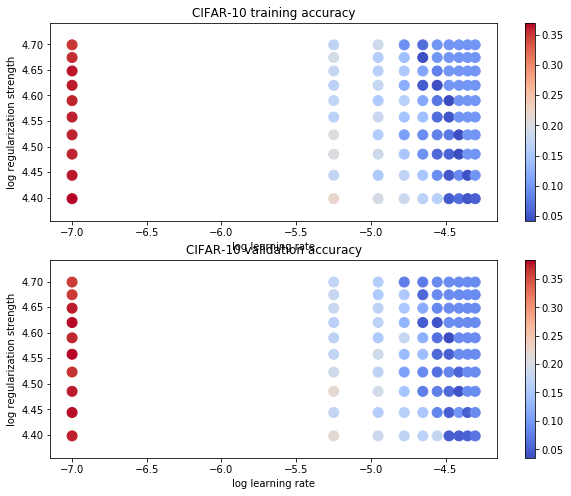

In [53]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [50]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.361000


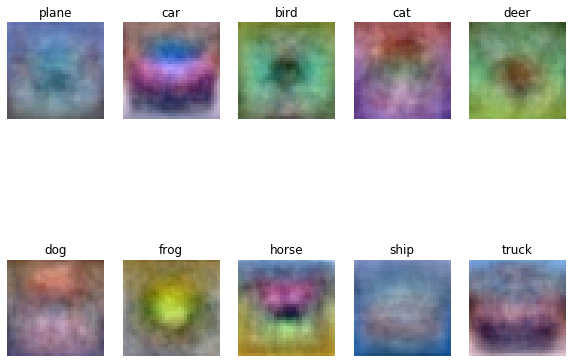

In [51]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  


In [46]:
xxx = np.array([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])

In [47]:
xxx N, D

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [52]:
yyy = np.array([[1,1,1],[2,2,2],[3,3,3],[4,4,4],[5,5,5],[6,6,6]]).T

In [56]:
ttt = np.array([1, 2, 3])

In [57]:
ttt.dot(yyy)

array([ 6, 12, 18, 24, 30, 36])

In [55]:
yyy

array([[1, 2, 3, 4, 5, 6],
       [1, 2, 3, 4, 5, 6],
       [1, 2, 3, 4, 5, 6]])

In [54]:
xxx.dot(yyy)

array([[  6,  12,  18,  24,  30,  36],
       [ 15,  30,  45,  60,  75,  90],
       [ 24,  48,  72,  96, 120, 144],
       [ 33,  66,  99, 132, 165, 198]])

In [35]:
hhh = np.array([[-11,-22],[3,4]])

In [70]:
hhh

array([[-11, -22],
       [  3,   4]])

In [71]:
np.maximum(hhh, 0)

array([[0, 0],
       [3, 4]])

In [36]:
hhh > 0

array([[False, False],
       [ True,  True]])

In [38]:
aaa = (hhh > 0)*1

In [39]:
aaa

array([[0, 0],
       [1, 1]])

In [ ]:
digitized = numpy.digitize(data, bins)


In [35]:

a = np.array([1,10])
b = np.digitize(a, 3)

ValueError: object of too small depth for desired array